# Model families and component inference
Ths notebook provides 2 examples of how to use model families to draw inferences about whether a specific component of a weighted model is necessary to explain the data or not. For the theoretical background, please see Model Inference -> Model families and component inference.

In [22]:
# Import the necessary modules 
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox as rsa
from scipy.spatial.distance import squareform
from scipy import io

## Simple 3 x 2 design
This is a classical example of a fully crossed design with two factors (A and B) and the possibility for an interaction between those two factors. In this MANOVA-like design it is important to orthogonalize the interaction and main effects when building the features for the 3 different components. 

#### Building a model family
First, we build a full model that we can use to generate data - and a model family that encodes all possible combinations of factor A, B and interaction.  

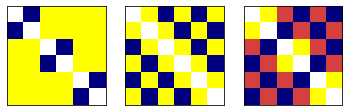

In [5]:
# Build simple one-hot encoding of the two main effects and interaction
A = np.array([[1.0,0,0],[1,0,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]])
B = np.array([[1.0,0],[0,1],[1,0],[0,1],[1,0],[0,1]])
I = np.eye(6)
# Orthogonalize the interaction
X= np.c_[A,B]
I = I-X @ np.linalg.pinv(X) @ I

# Now convert the features to squared-eucledian RDMs
rdms = np.zeros((3,6,6))
C =  rsa.util.matrix.pairwise_contrast(np.arange(6))
rdms[0]=squareform(np.diag(C@A@A.T@C.T))
rdms[1]=squareform(np.diag(C@B@B.T@C.T))
rdms[2]=squareform(np.diag(C@I@I.T@C.T))

# Build full model and model families
M = rsa.model.ModelWeighted('A+B+I',rdms)
MF= rsa.model.ModelFamily(rdms,comp_names=['A','B','I'])

# Show the three RDMs
f=rsa.vis.show_rdm(M.rdm_obj,n_row=1,n_column=3)


#### Generate artificial data
Now we are generating some artifical data, using a specific setting of theta. In this example, the main effect A is present, as well as weak interaction, but no main effect for B.  

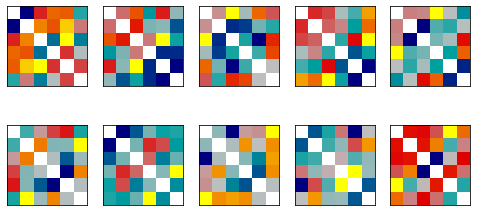

In [7]:
# Make condition and partition vector (for 8 runs)
[cond_vec,part_vec]=rsa.simulation.make_design(6,8)
# Generate 10 data sets 
D = rsa.simulation.make_dataset(M,
                            theta=np.array([0.5,0,0.1]),
                            cond_vec = cond_vec,
                            signal=0.1,
                            n_sim = 10,
                            n_channel=20,
                            part_vec = part_vec)
# Calculate the data RDMs 
data_rdms = rsa.rdm.calc_rdm(D,method='crossnobis',
                            descriptor='cond_vec',
                            cv_descriptor='part_vec')
# For visualization, show the claculated data RDMs.
f=rsa.vis.show_rdm(data_rdms,n_row=2,n_column=5)

#### Fitting the data 
Now we can fit the data using each model in the model family. The default fitter for the weighted models in the model family is `rsa.model.fitting.optimize_positive` - that is every component needs to be positively weighted. 

In [10]:
theta = []
for model in MF.models:
    theta.append(model.fit(data_rdms,method='cosine'))
Res=rsa.inference.eval_fixed(MF.models,data_rdms,theta=theta,method='cosine')


#### Inference: Model posterior
For the inference, we can use the cosine similarity or correlation to obtain an estimated likelihood of the RDM ($\mathbf{D}_j$ under the model, using a Normal approximation to the distances. 

$p(\mathbf{D}_j|M_i)=-\frac{K(K-1)/2}{2}log(1-R^2)$

Assuming a flat prior across models we can then estimate a posterior probability of model $M_i$.

$p(M_i|\mathbf{D}_j)=\frac{p(\mathbf{D}_j|M_i)p(M_i)}{\sum_k(p(\mathbf{D}_j|M_k)p(M_k)}$

The resulting posterior probabilities can be well illustrated in a model family graph. Each node is a model, presented in rows depending on the number of components they contain. Each edge signifies the addition (going up) or removal (going down) of a model component. 

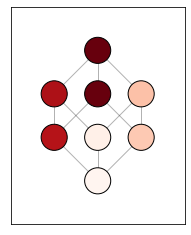

In [21]:
# Calculate the model posterior and return as ndarray 
mposterior = MF.model_posterior(Res,method=None,format='ndarray')
# Plot the first subjects posterior probabaility as a model family graph
rsa.vis.family_graph(MF,node_facecolor=mposterior.mean(axis=0))


#### Inference: Component posterior
We can also get the posterior probability for each component for each subject / data set. This is simply the sum of the posterior probabilties of all the model combinations that contain that component. The 0.5 line (this is the prior probability) is drawn. The lower line is the most evidence we can get for the absence of a model component using AIC. This is because, in the worst case, a new component does not increase the likelihood at all. This would result in the new component having a realtive likelihood that is 1.0 lower than the simpler model (parameter penality). Thus, overall the worst we can get p=1/(1+exp(1)). 

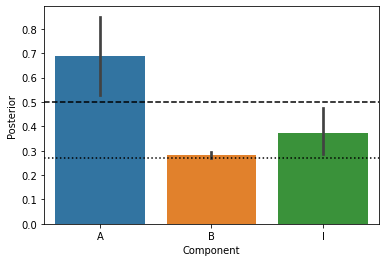

In [19]:
cposterior = MF.component_posterior(Res,method='AIC',format='DataFrame')
rsa.vis.component_barplot(cposterior,type='posterior')


#### Component Bayes factor 
For frequentist statistical testing and display, it is also often useful use the log-odds of the posterior $log(p/(1-p))$. For a flat prior across the model family, this is the bayes factor for the specific component, with positive values indicating evidence for the presence of the component and negative values evidence against the presence of the component. For inference, we often simply use a simple t-test across subjects (against) zero on the log Bayes factors. Alternatively you can also use a Bayesian group analysis (see inference). 

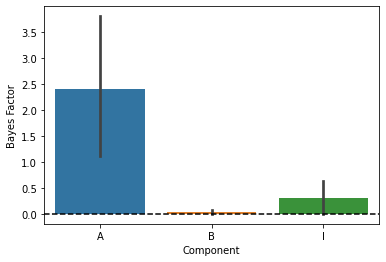

In [20]:
c_bf = MF.component_bayesfactor(Res,method=None,format='DataFrame')
rsa.vis.component_barplot(c_bf,type='bf')

## More complex co-linear example
....

(<Figure size 597.6x792 with 64 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
      

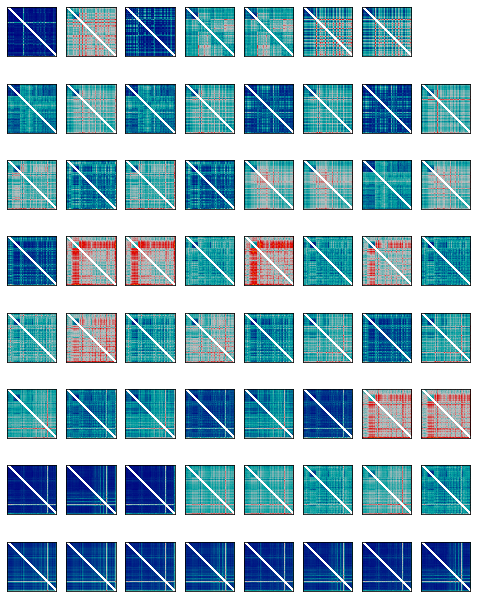

In [23]:
matlab_data = io.matlab.loadmat('rdms_inferring/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])
model_rdms = rsa.rdm.RDMs(
    rdms_array,
    rdm_descriptors={'brain_computational_model':model_names,
                     'measurement_model':measurement_model},
                     dissimilarity_measure='Euclidean'
    )

rsa.vis.show_rdm(model_rdms)

/Users/heiko/rsatoolbox/rsatoolbox/vis/model_plot.py:154: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'


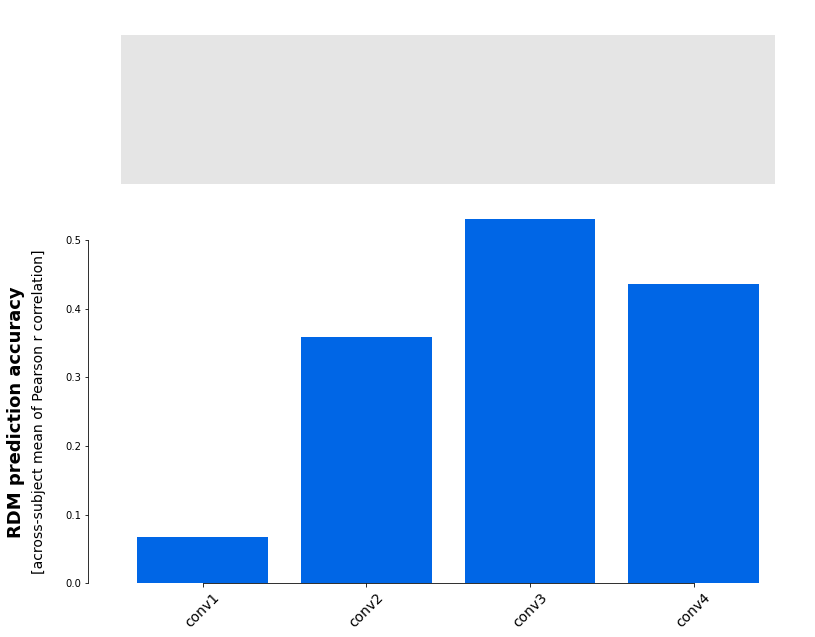

In [6]:
model_family = ModelFamily(models[0:4])

results = rsatoolbox.inference.crossval(models[0:4], rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results, test_type=None, error_bars=None)

### Evaluate model family and plot bars for each family member

/Users/heiko/rsatoolbox/rsatoolbox/vis/model_plot.py:154: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'
/Users/heiko/rsatoolbox/rsatoolbox/vis/model_plot.py:160: UserWarning: errorbars deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('errorbars deactivated as crossvalidation does not'


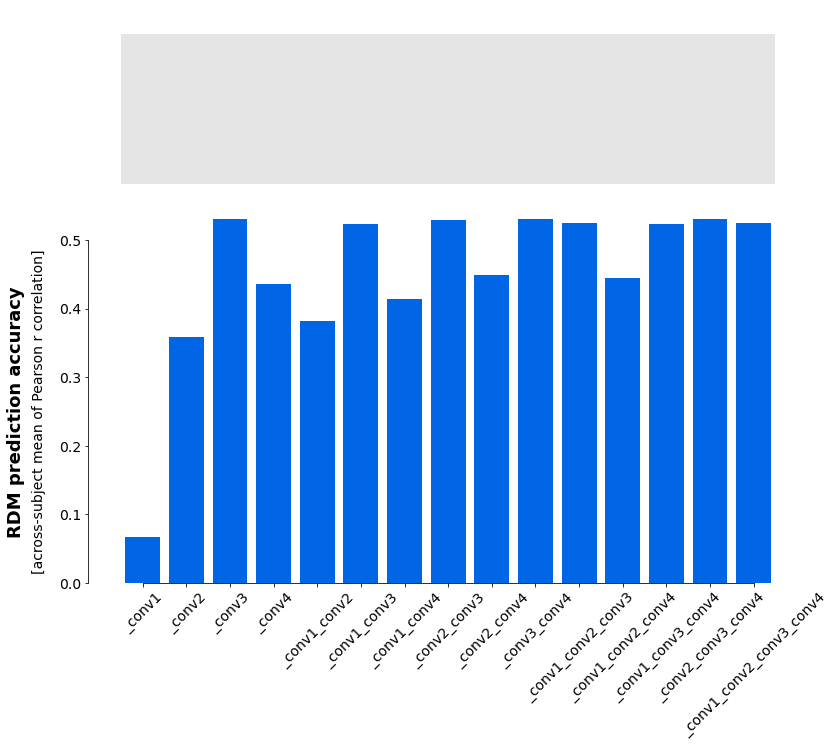

In [7]:
results = rsatoolbox.inference.crossval(model_family.get_all_family_members(), rdms_data, train_set, test_set,
                                        ceil_set=ceil_set, method='corr')
# plot results
rsatoolbox.vis.plot_model_comparison(results)

### visualizing family graph
We can visualize the above bar plot in a more convenient way using Graph where each node represents a family member.
1. Numbers inside the node represent which layers were selected in that family member. 
2. We can choose color/area of the node proportional to its performance. 
3. Edges are always directed towards increase in performance. 
4. The width of the edges indicates the improvement in performance when going from one node to other

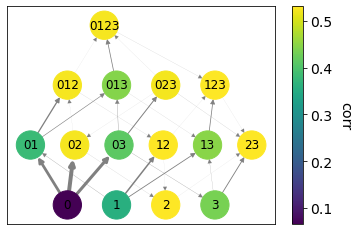

In [8]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color")

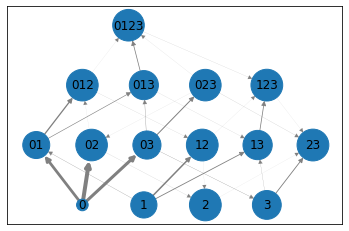

In [9]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="area")

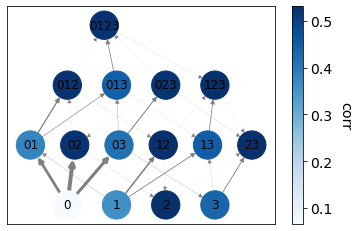

In [10]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color", cmap=plt.cm.Blues)

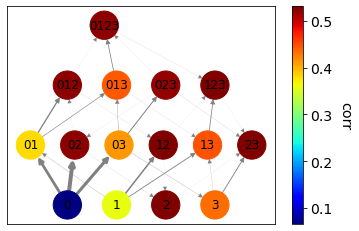

In [11]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color", cmap=plt.cm.jet)

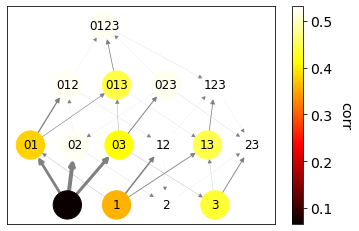

In [12]:
rsatoolbox.vis.show_family_graph(model_family, results, node_property="color", cmap=plt.cm.hot)

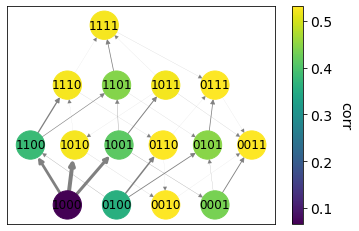

In [13]:
rsatoolbox.vis.show_family_graph(model_family, results, node_labels='binary', node_property="color")